# Differential Neural Network
## Single Layer

In [1]:
# Librerys
import numpy as np
import matplotlib.pyplot as plt
# Latex font
from matplotlib import rc
#It is no longer neccessary to resize the shapes 0f the matrices

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

##### The nonlinear system to be identified is given by

$x_t = f(x_t,u_t,t)$

$x_t \in \mathbb{R}^{n}; u_t \in \mathbb{R}^{q} ; q \leq n$

##### We assume the following parallel structure for neural networks

$\hat{x}_t = A\hat{x}_t + W_1\sigma(\hat{x}_t) + W_2\varphi(\hat{x}_t)u_t$

where:

$\hat{x}_t \in \mathbb{R}^{n}$ is the state of the neural network 

$u_t \in \mathbb{R}^{q}$ is an input measurable action

$W_{1,t} \in \mathbb{R}^{n\times k}$ is the matrix for non linear state feedback

$W_{2,t} \in \mathbb{R}^{n\times r}$ is the input matrix

$A \in \mathbb{R}^{n \times n } $ is a Hurwitz Matrix


#### Activation Functions

$\sigma_i = a_i(1 + e^{-b_i x_t})^{-1}$

$\varphi_{i,j} = a_{i,j}(1 + e^{-b_{i,j} x_t})^{-1}$

In [3]:
#First we need to define the activation functions
#This functions next will be custumized to have different vectors and parameters
#The activation functions will convert from a vector field to antoher in the DNN
def functionSigma(x):
    s = np.zeros((4,1))
    
    z = -1*(x[0]*-1 + x[1]*-1.2)*15
    s[0,0] = 1/(1 + np.exp(z))
    
    z = -1*(x[0]*-1 + x[1]*1)*15
    s[1,0] = 1/(1 + np.exp(z))
    
    z = -1*(x[0]*1 + x[1]*-1.2)*15
    s[2,0] = 1/(1 + np.exp(z))
    
    z = -1*(x[0]*1.2 + x[1]*1)*4
    s[3,0] = 1.1/(1 + np.exp(z))
    return s

def functionPhi(x):
    s = np.zeros((2,1))#Variable para guardar resultados
    
    z = -1*(x[0]*1 + x[1]*-1) #Multilicacion de vectores
    s[0,0] = 1/(1 + np.exp(z))
    
    z = -1*(x[0]*1 + x[1]*-1)#Multilicacion de vectores
    s[1,0] = 1/(1 + np.exp(z))
    
    s = s@np.ones((1,1))#Multiplicación por una matriz
    
    return s


X = np.ones((2,1))
y = functionSigma(X)
print(y)
print(np.shape(y))
z = functionPhi(X)
print(np.shape(z))
print(z)        

[[4.65888615e-15]
 [5.00000000e-01]
 [4.74258732e-02]
 [1.09983422e+00]]
(4, 1)
(2, 1)
[[0.5]
 [0.5]]


#### Learning laws

$\dot{W}_i = K_1P\Delta_t \sigma(\hat{x}_t)$

$\dot{W}_2 = K_2P\Delta_t \varphi(\hat{x}_t)u_t$



In [4]:
#Then we need to define the learning laws of the DNN identifier

def LAW1(W1_a,delta,k1,P,xh,dT):
    W1 = dT*(k1@P@delta@functionSigma(xh).T) + W1_a
    return W1

def LAW2(W2_a,delta,k2,P,xh,u,dT):
    W2 = dT*(k2@P@delta@functionPhi(xh).T*u) + W2_a
    return W2


To prove the behavior of the DNN let us introduce the Van Der Pol oscillator which is an unknown nonlinear system. The state equations that describes the system are the following:

$\dot{x}_1=x_2 \\
\dot{x}_2=-x_1+\varepsilon x_2(1-x_1^2)+w(t)+u$

The simulation will run 30 seconds

In [5]:
# Simulation Time
Tau = 100 #time in seconds
dt = 0.001 # time step
t = int(Tau/dt) # n time steps
# Van der poll simulation parameters
epsilon = 2;#The epsilon parameter
u = 0.3;#External input
# Initial conditions
xs = np.zeros((2,t)) #Van Der Poll Oscillator
# Diferential neural network parameters
xh = np.zeros((2,t)) #DNN State
# Matrix A
A = np.array([[-0.35,0],
              [0,-0.51]])*4
# Number of neurons
#This is for a future update of the activation functions
nn1 = 4;
nn2 = 2;
# Weights 
W1 = np.zeros((2,nn1,t))
W1[:,:,0] = np.random.random((2,nn1))*2-1#For first traning
#W1[:,:,0] = W1[:,:,-1]#To save previus wieghts


W2 = np.zeros((2,nn2,t))
W2[:,:,0] = np.random.random((2,nn2))*2-1#For first training
#W2[:,:,0] = W2[:,:,-1]
# Identification error
delta = np.zeros((2,t))
#Training
k1 = np.array([[1,0],
              [0,1.2]])*2
k2 = np.array([[1,0],
              [0,1]])*1
P = np.array([[50,0],
              [0,50]])*1
print(A)

[[-1.4   0.  ]
 [ 0.   -2.04]]


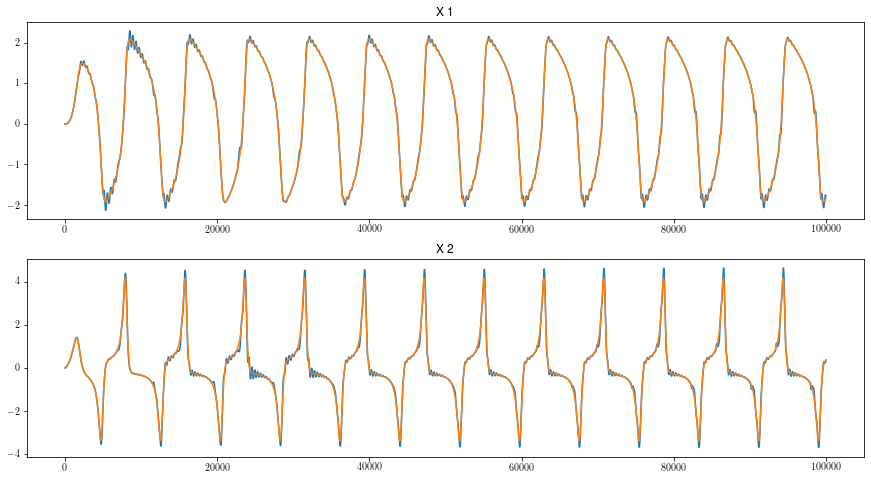

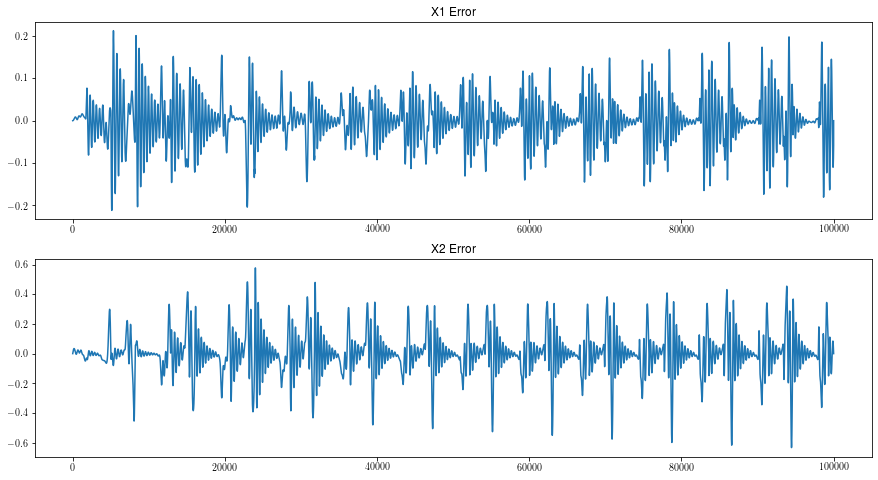

In [6]:
W1[:,:,0] = W1[:,:,-1]#To save previus wieghts
W2[:,:,0] = W2[:,:,-1]#To save previus wieghts
xs = np.zeros((2,1,t))
xh = np.zeros((2,1,t))
Delta = np.zeros((2,1,t))
for i in range(t-1):
    xs[0,0,i+1] = (xs[1,0,i])*dt + xs[0,0,i]
    xs[1,0,i+1] = (-xs[0,0,i] + epsilon*xs[1,0,i]*(1-xs[0,0,i]*xs[0,0,i]) + u)*dt + xs[1,0,i]
    delta = xs[:,:,i]-xh[:,:,i]
    Delta[:,:,i] = delta
    W1[:,:,i+1] = LAW1(W1[:,:,i],delta,k1,P,xh[:,0,i],dt)
    W2[:,:,i+1] = LAW2(W2[:,:,i],delta,k1,P,xh[:,0,i],u,dt)
    X = dt*(A@xh[:,:,i] + W1[:,:,i]@functionSigma(xh[:,:,i]) + W2[:,:,i]@functionPhi(xh[:,:,i])*u)
    xh[:,:,i+1] = X + xh[:,:,i]
    ## Loss
# Plotting both states of the Van der pol oscilator
fig = plt.figure(figsize = [15,8]);
plt.subplot(211);
plt.title('X 1')
plt.plot(xh[0,0,:]);
plt.plot(xs[0,0,:]);
plt.subplot(212);
plt.title('X 2')
plt.plot(xh[1,0,:]);
plt.plot(xs[1,0,:]);
plt.savefig('Identificacion.png')
#Plotting Error 
fig = plt.figure(figsize = [15,8]);
plt.subplot(211);
plt.title('X1 Error')
plt.plot(Delta[0,0,:]);
plt.subplot(212);
plt.title('X2 Error')
plt.plot(Delta[1,0,:]);
plt.savefig('IdentificacionError.png')

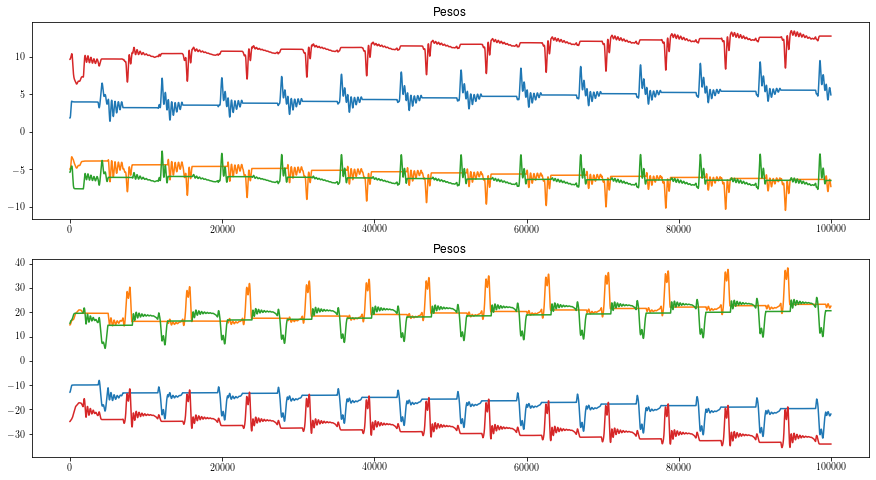

In [44]:
fig = plt.figure(figsize = [15,8]);
plt.subplot(211);
plt.title('Pesos')
plt.plot(W1[0,0,:]);
plt.plot(W1[0,1,:]);
plt.plot(W1[0,2,:]);
plt.plot(W1[0,3,:]);
plt.subplot(212);
plt.title('Pesos')
plt.plot(W1[1,0,:]);
plt.plot(W1[1,1,:]);
plt.plot(W1[1,2,:]);
plt.plot(W1[1,3,:]);
plt.savefig('books_read.png')

(2, 1, 1000)

array([0., 0.])